# Example 3: visualize effect of field-dependence of PSF across FOV

This script walks through the generation of a figure that demonstrates the effect of the field-dependence of the Roman WFI PSF across the field of view.

Note that the field-dependence of the PSF is currently *not* supported by Pandeia (v3.0) as of January 2024. We circumvent this by deconvolving the Pandeia PSF then reconvolving with an off-center PSF to approximate this effect.

In [21]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from hydra import initialize, compose
from glob import glob
from copy import deepcopy
from PIL import Image
import matplotlib.patches as patches
from webbpsf import roman
from skimage import restoration
from astropy import convolution

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input, psf

For this example, let's load a sample strong lens system. We'll consider it imaged by the F184 band since its PSF has the greatest FWHM and will therefore be the most noticable.

Its parameters can be accessed through its `kwargs_model` and `kwargs_params` (dict) attributes.

In [22]:
lens = SampleSkyPyStrongLens()

num_pix = 45
side = 4.95
band = 'f184'
supersample_factor = 3
num_samples = 100000

# add CDM subhalos
lens.add_subhalos(*pyhalo.generate_CDM_halos(lens.z_lens, lens.z_source, cone_opening_angle_arcsec=6.))

model = lens.get_array(num_pix=51 * supersample_factor, side=5.61)

First, we generate an image with Pandeia with sky background and all detector noise sources off. 

The Pandeia calculation takes around 15 minutes for each image, so set `calculate = True` the first time which will save the result, then set `calculate = False` for subsequent runs which will just load the saved arrays.

In [23]:
calculate = True

if calculate:
    calc, _ = pandeia_input.build_pandeia_calc(model, 
                                            lens, 
                                            background=False, 
                                            band=band, 
                                            max_scene_size=5, 
                                            noise=False, 
                                            num_samples=num_samples, 
                                            suppress_output=False)
    pandeia_off, _ = pandeia_input.get_pandeia_image(calc, suppress_output=False)
    np.save('pandeia_off', pandeia_off)

100%|██████████| 11333/11333 [01:18<00:00, 144.44it/s]


Point source conversion complete: placed 11333 point sources
Estimated calculation time: 0:14:50
Performing Pandeia calculation...
Pandeia calculation complete in 0:12:27


Next, we generate an image with sky background and all detector noise sources turned on.

In [24]:
if calculate:
    calc, _ = pandeia_input.build_pandeia_calc(model, 
                                            lens, 
                                            background=True, 
                                            band=band, 
                                            max_scene_size=5, 
                                            noise=True, 
                                            num_samples=num_samples, 
                                            suppress_output=False)
    pandeia_on, _ = pandeia_input.get_pandeia_image(calc)
    np.save('pandeia_on', pandeia_on)

100%|██████████| 11296/11296 [01:15<00:00, 149.32it/s]


Point source conversion complete: placed 11296 point sources
Estimated calculation time: 0:14:47
Performing Pandeia calculation...
Pandeia calculation complete in 0:12:16


In [25]:
pandeia_off = np.load('pandeia_off.npy')
pandeia_on = np.load('pandeia_on.npy')

The difference of these images will give us the detector noise and (PSF-convolved) sky background.

In [26]:
noise_and_convolved_bkg = pandeia_on - pandeia_off

The PSF that Pandeia uses is taken at the center (position 2048, 2048) of the SCA01 chip. This is the default for WebbPSF. We generate this PSF with WebbPSF, then deconvolve the sky background and noise *off* image.

In [27]:
wfi = roman.WFI()
wfi.filter = 'F184'
print(f'{wfi.detector}, {wfi.detector_position}')
calc_psf = wfi.calc_psf(oversample=supersample_factor)
pandeia_kernel = psf.get_kernel_from_calc_psf(calc_psf)

deconvolved = restoration.richardson_lucy(pandeia_off, pandeia_kernel, num_iter=30, clip=False)

SCA01, (2048, 2048)


Now, we can re-convolve this image with various PSFs across the Roman WFI field of view. We generate these PSFs using WebbPSF.

In [28]:
# get kernels
wfi_05 = roman.WFI()
wfi_05.filter = 'F184'
wfi_05.detector = 'SCA05'
wfi_05.detector_position = (1024, 3072)
calc_psf_05 = wfi_05.calc_psf(oversample=supersample_factor)
kernel_sca05 = psf.get_kernel_from_calc_psf(calc_psf_05)

wfi_09 = roman.WFI()
wfi_09.filter = 'F184'
wfi_09.detector = 'SCA09'
wfi_09.detector_position = (4, 4)
calc_psf_09 = wfi_09.calc_psf(oversample=supersample_factor)
kernel_sca09 = psf.get_kernel_from_calc_psf(calc_psf_09)

wfi_11 = roman.WFI()
wfi_11.filter = 'F184'
wfi_11.detector = 'SCA11'
wfi_11.detector_position = (4, 4092)
calc_psf_11 = wfi_11.calc_psf(oversample=supersample_factor)
kernel_sca11 = psf.get_kernel_from_calc_psf(calc_psf_11)

wfi_15 = roman.WFI()
wfi_15.filter = 'F184'
wfi_15.detector = 'SCA15'
wfi_15.detector_position = (3072, 1024)
calc_psf_15 = wfi_15.calc_psf(oversample=supersample_factor)
kernel_sca15 = psf.get_kernel_from_calc_psf(calc_psf_15)

wfi_16 = roman.WFI()
wfi_16.filter = 'F184'
wfi_16.detector = 'SCA16'
wfi_16.detector_position = (4092, 4092)
calc_psf_16 = wfi_16.calc_psf(oversample=supersample_factor)
kernel_sca16 = psf.get_kernel_from_calc_psf(calc_psf_16)

Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the range of the reference data; approximating to nearest interpolated point (3.9904546744231357, 43.00220030706667)
Attempted to get aberrations at field point (4, 4) which is outside the ran

We do the convolution and add back the sky background and detector noise. 

Note that the sky background was convolved with the centered PSF, so this method is only approximate.

In [29]:
image_05 = convolution.convolve(deconvolved, kernel_sca05)
image_09 = convolution.convolve(deconvolved, kernel_sca09)
image_11 = convolution.convolve(deconvolved, kernel_sca11)
image_15 = convolution.convolve(deconvolved, kernel_sca15)
image_16 = convolution.convolve(deconvolved, kernel_sca16)

image_05 += noise_and_convolved_bkg
image_09 += noise_and_convolved_bkg
image_11 += noise_and_convolved_bkg
image_15 += noise_and_convolved_bkg
image_16 += noise_and_convolved_bkg

Take a quick look at the images across the field of view.

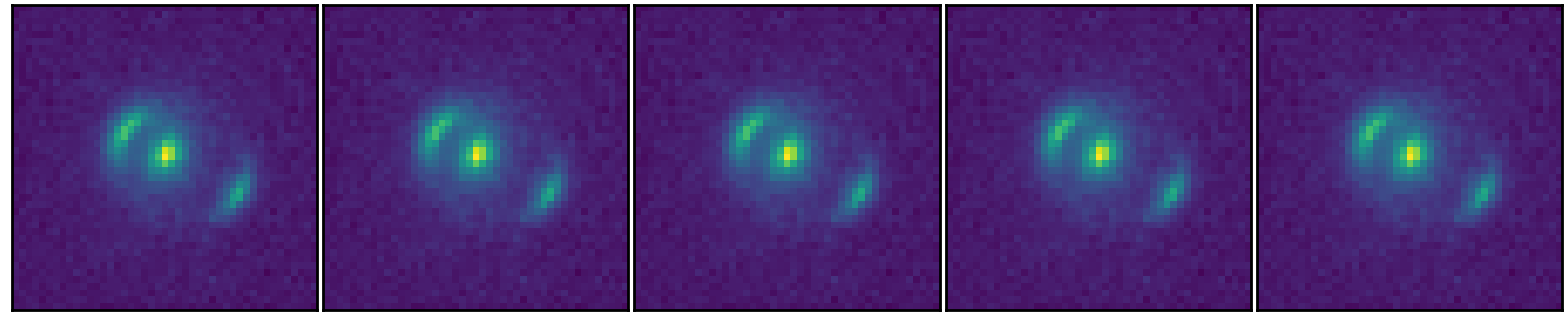

In [30]:
plot.plot_list([image_05, image_09, image_11, image_15, image_16])

Consider the differences between the strong lens centered on the SCA01 detector and the lenses across the field of view.

In [31]:
residual_05 = image_11 - image_05
residual_09 = image_11 - image_09
residual_15 = image_11 - image_15
residual_16 = image_11 - image_16

Generate a figure showing these residuals and their positions across the Roman FOV.

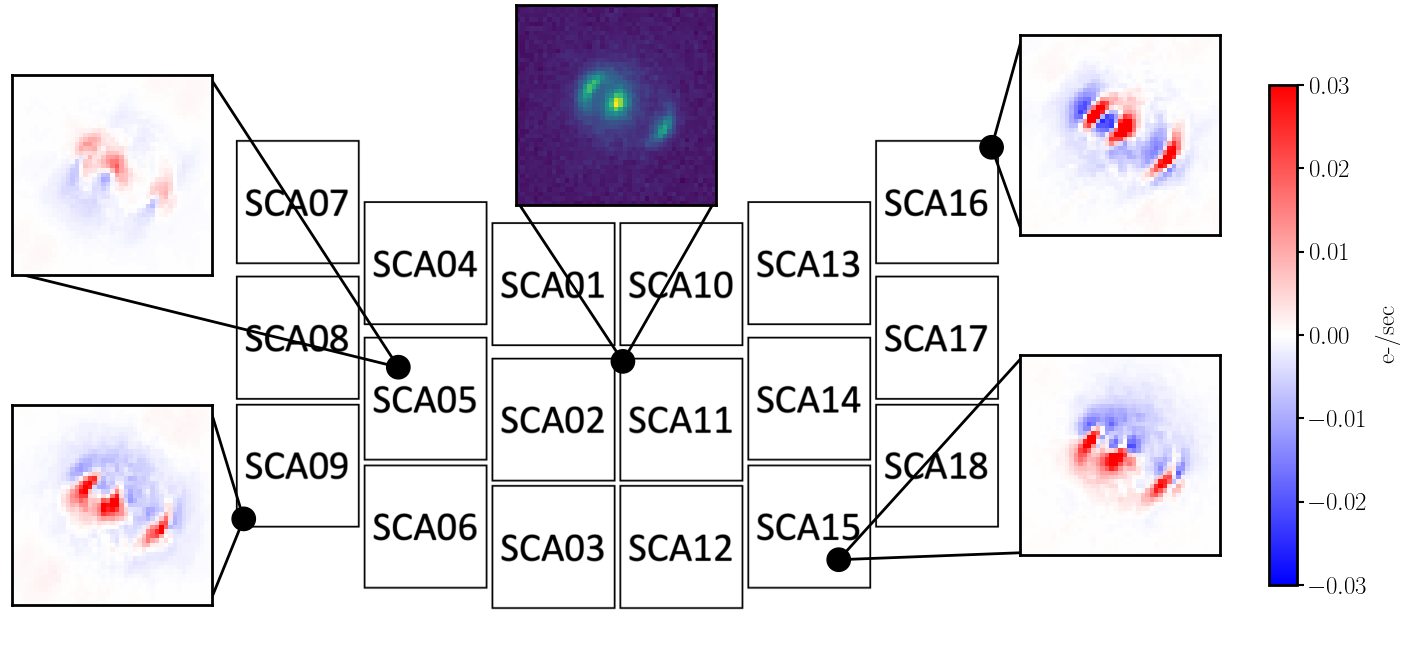

In [32]:
f, ax = plt.subplots(figsize=(14, 10))

fov = np.asarray(Image.open('../paper/graphics/roman_fov.png'))
ax.imshow(fov, origin='upper')
ax.set_axis_off()

vmin, vmax = -0.03, 0.03

circ_05_coords = (535, 535)
circ_05 = patches.Circle(circ_05_coords, radius=20, color='black')
point_05 = ax.add_patch(circ_05)
ax_05 = f.add_axes([0.015,0.58,0.2,0.2], anchor='NE', zorder=1)
im = ax_05.imshow(residual_05, cmap='bwr', vmin=vmin, vmax=vmax)
ax_05.spines[:].set_linewidth(2.)
ax_05.set_xticks([])
ax_05.set_yticks([])
con_05_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_05.transData, xyB=circ_05_coords, coordsB=ax.transData)
con_05_b.set_linewidth(2)
con_05_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_05.transData, xyB=circ_05_coords, coordsB=ax.transData)
con_05_t.set_linewidth(2)
ax.add_artist(con_05_b)
ax.add_artist(con_05_t)

circ_09_coords = (270, 795)
circ_09 = patches.Circle(circ_09_coords, radius=20, color='black')
point_09 = ax.add_patch(circ_09)
ax_09 = f.add_axes([0.015,0.25,0.2,0.2], anchor='NE', zorder=1)
ax_09.imshow(residual_09, cmap='bwr', vmin=vmin, vmax=vmax)
ax_09.spines[:].set_linewidth(2.)
ax_09.set_xticks([])
ax_09.set_yticks([])
con_09_b = patches.ConnectionPatch(xyA=(44,0), coordsA=ax_09.transData, xyB=circ_09_coords, coordsB=ax.transData)
con_09_b.set_linewidth(2)
con_09_t = patches.ConnectionPatch(xyA=(44,44), coordsA=ax_09.transData, xyB=circ_09_coords, coordsB=ax.transData)
con_09_t.set_linewidth(2)
ax.add_artist(con_09_b)
ax.add_artist(con_09_t)

circ_11_coords = (920, 525)
circ_11 = patches.Circle(circ_11_coords, radius=20, color='black')
point_11 = ax.add_patch(circ_11)
ax_11 = f.add_axes([0.375,0.65,0.2,0.2], anchor='NE', zorder=1)
ax_11.imshow(image_11, cmap='viridis')
ax_11.spines[:].set_linewidth(2.)
ax_11.set_xticks([])
ax_11.set_yticks([])
con_11_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_11.transData, xyB=circ_11_coords, coordsB=ax.transData)
con_11_b.set_linewidth(2)
con_11_t = patches.ConnectionPatch(xyA=(44,0), coordsA=ax_11.transData, xyB=circ_11_coords, coordsB=ax.transData)
con_11_t.set_linewidth(2)
ax.add_artist(con_11_b)
ax.add_artist(con_11_t)

circ_15_coords = (1290, 865)
circ_15 = patches.Circle(circ_15_coords, radius=20, color='black')
point_15 = ax.add_patch(circ_15)
ax_15 = f.add_axes([0.735,0.3,0.2,0.2], anchor='NE', zorder=1)
ax_15.imshow(residual_15, cmap='bwr', vmin=vmin, vmax=vmax)
ax_15.spines[:].set_linewidth(2.)
ax_15.set_xticks([])
ax_15.set_yticks([])
con_15_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_15.transData, xyB=circ_15_coords, coordsB=ax.transData)
con_15_b.set_linewidth(2)
con_15_t = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_15.transData, xyB=circ_15_coords, coordsB=ax.transData)
con_15_t.set_linewidth(2)
ax.add_artist(con_15_b)
ax.add_artist(con_15_t)

circ_16_coords = (1552, 158)
circ_16 = patches.Circle(circ_16_coords, radius=20, color='black')
point_16 = ax.add_patch(circ_16)
ax_16 = f.add_axes([0.735,0.62,0.2,0.2], anchor='NE', zorder=1)
ax_16.imshow(residual_16, cmap='bwr', vmin=vmin, vmax=vmax)
ax_16.spines[:].set_linewidth(2.)
ax_16.set_xticks([])
ax_16.set_yticks([])
con_16_b = patches.ConnectionPatch(xyA=(0,0), coordsA=ax_16.transData, xyB=circ_16_coords, coordsB=ax.transData)
con_16_b.set_linewidth(2)
con_16_t = patches.ConnectionPatch(xyA=(0,44), coordsA=ax_16.transData, xyB=circ_16_coords, coordsB=ax.transData)
con_16_t.set_linewidth(2)
ax.add_artist(con_16_b)
ax.add_artist(con_16_t)

cax = f.add_axes([0.97, 0.27, 0.02, 0.5])
cbar = f.colorbar(im, cax=cax)
cbar.set_label('e-/sec', rotation=90)

plt.show()